In [1]:
# Install packages
!pip install -q keras-eval stored matplotlib plotly

In [2]:
%matplotlib inline
import os
import numpy as np
import keras_eval.eval as eval
# Plot Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
import matplotlib
# Set GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [3]:
import stored
# Download Test Dataset
stored.sync('https://storage.googleapis.com/sample-datasets/cats-vs-dogs/valid.zip', 'data/valid')

## Evaluator

Easy predictions and evaluations for a single model or an ensemble of many models.

You can add a model directly in the constructor, specifying the `model_path`, you will need to have its `model_spec.json` in the same folder too: 

The image preprocessing arguments are contained in `model_spec.json`. You can change the target_size to evaluate different image sizes. 

In [4]:
model_path = 'tmp/fixtures/models/ensemble/mobilenet_1/catdog-mobilenet.hdf5'

In [5]:
evaluator = eval.Evaluator(
        data_dir=None,
        concept_dictionary_path=None,
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0)

If you forgot to add it, or want to add more, you can do it with this function: 

In [6]:
evaluator.add_model(model_path = 'tmp/fixtures/models/ensemble/mobilenet_2/catdog-mobilenet.hdf5')

In [7]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  2


If you want to remove a model, you just have to specify its index. Let's remove the last added:

In [8]:
evaluator.remove_model(model_index=1)

In [9]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  1


## Evaluation Functions

### Evaluate a set of images. 

Each sub-folder under `'data_dir/'` will be considered as a different class. E.g. `'data_dir/class_1/dog.jpg'` , `'data_dir/class_2/cat.jpg'`
If you are evaluating an ensemble of models, we currently allow for these probability combination modes: `'maximum'`, `'arithmetic'`, `'geometric'`, `'harmonic'`

**evaluate**

In [10]:
data_dir = 'data/valid/'
probs, labels = evaluator.evaluate(data_dir=data_dir, top_k=1, filter_indices=None, confusion_matrix=False, save_confusion_matrix_path=None)

Making predictions from model  0
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 13s 200ms/step


In [11]:
# Print Results 
evaluator.show_results('average')

,model,accuracy,precision,f1_score,number_of_samples,number_of_classes
0,catdog-mobilenet.hdf5,0.583,0.643,0.534,2000,2


In [12]:
# Print Results per each class
evaluator.show_results('individual')

,class,sensitivity,precision,f1_score,specificity,FDR,AUROC,TP,FP,FN,% of samples
0,cats,0.907,0.550,0.685,0.259,0.450,1.0,907,741,93,50.0
1,dogs,0.259,0.736,0.383,0.907,0.264,1.0,259,93,741,50.0


In [13]:
# Check Shapes
print(probs.shape) # [n_models, n_samples, n_classes]
print(labels.shape) # [n_samples, n_classes]

(1, 2000, 2)
(2000, 2)


Also you can set the names for each class using a list of dictionaries as follows:

In [14]:
concepts = [{'label':'Dog', 'id': 'dogs'},
           {'label':'Cat', 'id': 'cats'}]

evaluator.set_concepts(concepts)

If you want to show a pretty **Confusion Matrix** set `confusion_matrix=True` and you can store it too by setting `save_confusion_matrix_path='name.png'`

Making predictions from model  0
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 12s 191ms/step


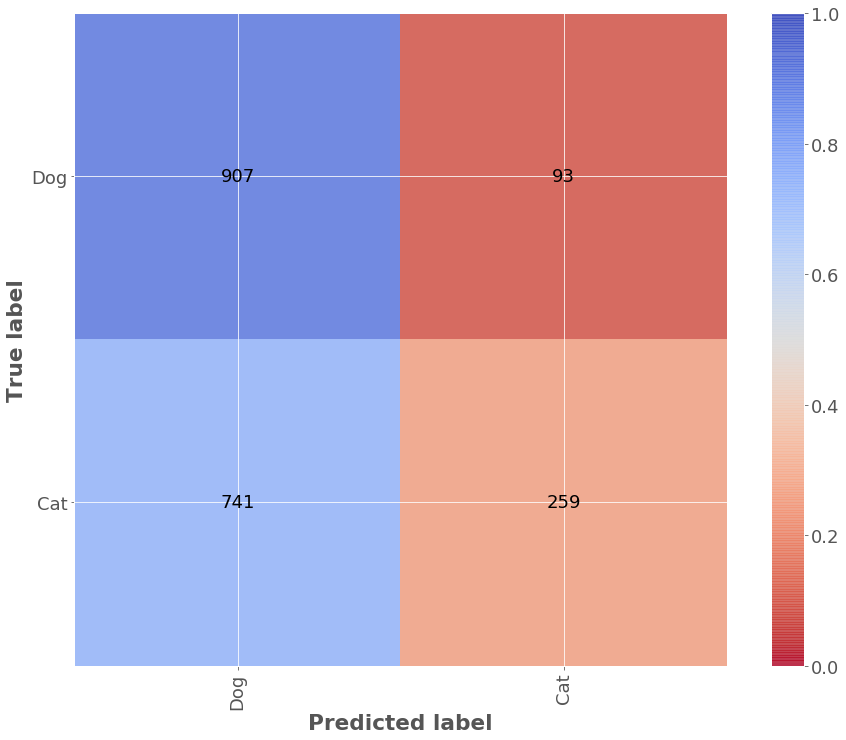

In [15]:
probs, labels = evaluator.evaluate(data_dir=data_dir, top_k=2, confusion_matrix=True, save_confusion_matrix_path='cm.png')

In [16]:
evaluator.show_results('average')

,model,accuracy_top_1,accuracy_top_2,precision,f1_score,number_of_samples,number_of_classes
0,catdog-mobilenet.hdf5,0.583,1.0,0.643,0.534,2000,2


In [17]:
evaluator.show_results('individual')

,class,sensitivity_top_1,sensitivity_top_2,precision,f1_score,specificity,FDR,AUROC,TP,FP,FN,% of samples
0,dogs,0.907,1.0,0.550,0.685,0.259,0.450,1.0,907,741,93,50.0
1,cats,0.259,1.0,0.736,0.383,0.907,0.264,1.0,259,93,741,50.0


* You can plot the **Receiver Operating Characteristic (ROC)** curve:

In [24]:
from keras_eval.visualizer import plot_ROC_curve

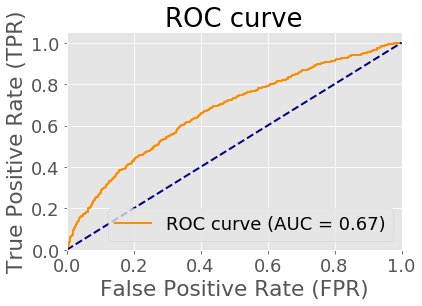

In [26]:
plot_ROC_curve(probs[0][:,1], labels[:,1])

* As well as the **Precision-Recall curve**:

In [27]:
from keras_eval.visualizer import plot_precision_recall_curve

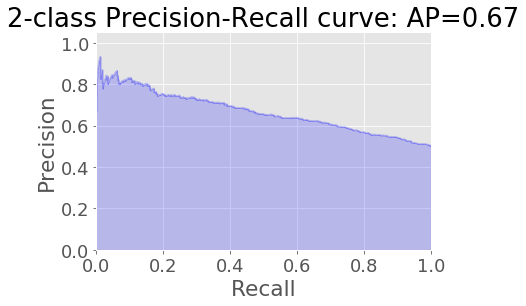

In [28]:
plot_precision_recall_curve(probs[0][:,1], labels[:,1])

These were the labels by default, but you can set custom names for your classes!

Plotting the sensitivity of each class and the global model accuracy: 

In [29]:
evaluator.plot_top_k_accuracy()

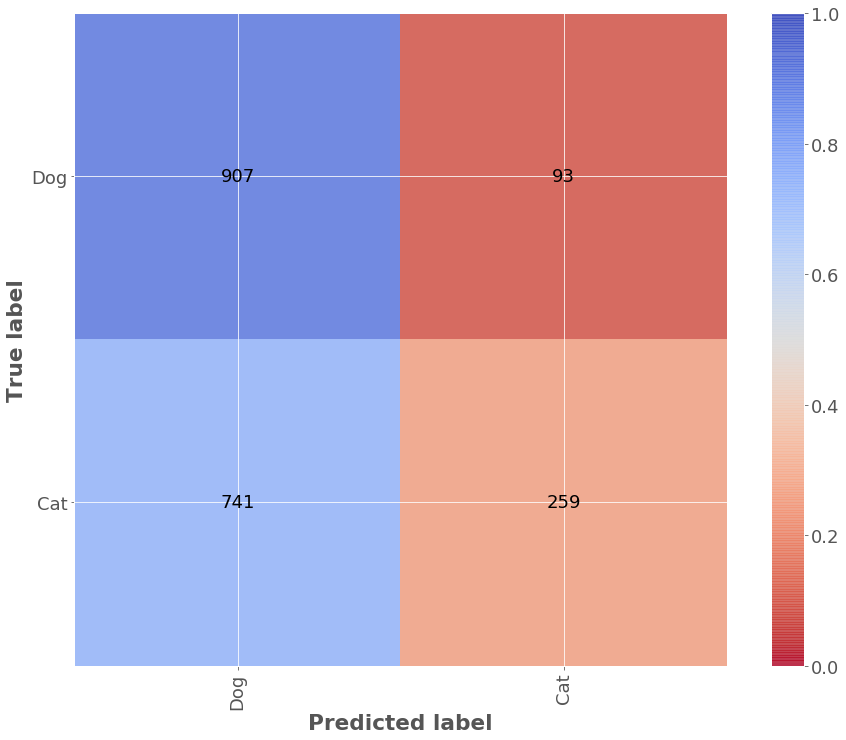

In [30]:
evaluator.plot_confusion_matrix(evaluator.results['average']['confusion_matrix'])

You can obtain the correct/erroneous images for every square of the confusion matrix

In [31]:
dict_image_paths = evaluator.get_image_paths_by_prediction(probs[0], labels)

We'll print the images of dogs confused as cats

In [32]:
print(dict_image_paths['Dog_Cat'])

['data/valid/cats/cat.10026.jpg', 'data/valid/cats/cat.10050.jpg', 'data/valid/cats/cat.10107.jpg', 'data/valid/cats/cat.10131.jpg', 'data/valid/cats/cat.10145.jpg', 'data/valid/cats/cat.10166.jpg', 'data/valid/cats/cat.1031.jpg', 'data/valid/cats/cat.10367.jpg', 'data/valid/cats/cat.10588.jpg', 'data/valid/cats/cat.10667.jpg', 'data/valid/cats/cat.10712.jpg', 'data/valid/cats/cat.11142.jpg', 'data/valid/cats/cat.11235.jpg', 'data/valid/cats/cat.11278.jpg', 'data/valid/cats/cat.11560.jpg', 'data/valid/cats/cat.1161.jpg', 'data/valid/cats/cat.11939.jpg', 'data/valid/cats/cat.12014.jpg', 'data/valid/cats/cat.12267.jpg', 'data/valid/cats/cat.1703.jpg', 'data/valid/cats/cat.1714.jpg', 'data/valid/cats/cat.1743.jpg', 'data/valid/cats/cat.1749.jpg', 'data/valid/cats/cat.1766.jpg', 'data/valid/cats/cat.2128.jpg', 'data/valid/cats/cat.2238.jpg', 'data/valid/cats/cat.2318.jpg', 'data/valid/cats/cat.2537.jpg', 'data/valid/cats/cat.259.jpg', 'data/valid/cats/cat.2647.jpg', 'data/valid/cats/cat.29

We can also plot them with:

/home/adria/Github/keras-eval/.venv/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



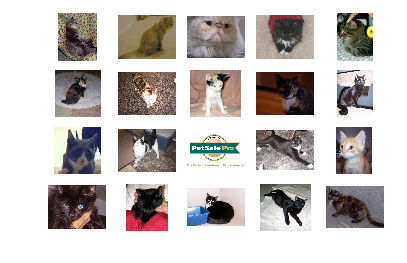

In [33]:
# We'll print the first 20
evaluator.plot_images(dict_image_paths['Dog_Cat'], n_imgs=20)

Effect on the number of correct predictions detected, error predictions removed when thresholding on probability. 
It is equivalent of only accepting prediction if the top-1 probability is > than the threshold:

In [34]:
# Threholds from 0 to 1, taking steps of 0.01
import numpy as np
threshold = np.arange(0, 1.01, 0.01)
correct_list, errors_list, n_correct, n_errors = evaluator.show_threshold_impact(probs, labels, type='probability')

Returning correct predictions and errors for the top k:  [1]


### Predict class probabilities of a set of images from a folder.

**predict**

In [35]:
folder_path = 'data/valid/cats/'
probs = evaluator.predict(folder_path)

Making predictions from model  0
1000/1000 [==============================] - 1s 937us/step


You can access to the predicted image paths, they are contained in `evaluator.image_paths`

This is what the image looks like: 


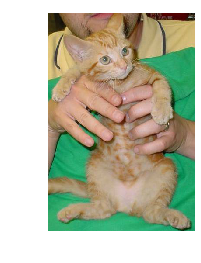

In [36]:
# We will plot the first image
image_0 = evaluator.image_paths[0]
plt.imshow(mpimg.imread(image_0))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [37]:
print('These are the probabilities for the first image: ') # Probabilities of the first image predicted
for index, c in enumerate(concepts):
    print('Probability for ' + c['label'] + ' class is %.4f'%probs[0, 0, index])

These are the probabilities for the first image: 
Probability for Dog class is 0.8475
Probability for Cat class is 0.1525


### Predict class probabilities for a single image

**predict**

This is what the image looks like: 


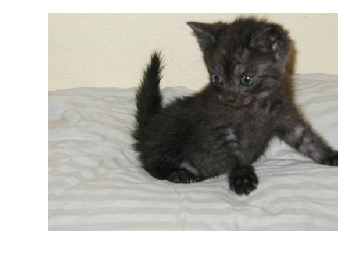

In [38]:
# We'll show the image we want to predict
image_path = 'data/valid/cats/cat.11878.jpg'
plt.imshow(mpimg.imread(image_path))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [39]:
probs = evaluator.predict(image_path)

Making predictions from model  0
1/1 [==============================] - 0s 66ms/step


In [40]:
for index, c in enumerate(concepts):
    print('Probability for ' + c['label'] + ' class is %.4f'%probs[0, 0, index])

Probability for Dog class is 0.5827
Probability for Cat class is 0.4173


### Using an ensemble of multiple models

We allow using evaluating multiple models at once. The models should have been trained on the same classes.
You can add the models separately, or all together, using the parameter `ensemble_models_dir`, every model should be in a separate folder. 
The parameter `combination_mode` is used to set the way of combining probabilities before evaluating. There are 4 modes available: `'arithmetic'`, `'maximum'`, `'geometric'` and `'harmonic'`. 

In [41]:
evaluator = eval.Evaluator(
        id='cats-vs-dogs',
        data_dir='data/valid/',
        concepts=[{'label': 'Cat', 'id': 'cat'}, {'label': 'Dog', 'id': 'dog'}],
        ensemble_models_dir='tmp/fixtures/models/ensemble/',
        combination_mode='arithmetic',
        model_path=None,
        batch_size=32,
        verbose=0)

Loading model  catdog-mobilenet.hdf5
Loading model  catdog-mobilenet.hdf5
Models loaded:  2


In [42]:
probs, labels = evaluator.evaluate()

Making predictions from model  0
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 12s 198ms/step
Making predictions from model  1
Input image size:  [224, 224, 3]
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 12s 192ms/step


By default we return the probabilities of both models separately. But you can have the combined probabilities by accessing `evaluator.combined_probabilities`. 

In [56]:
# All models predictions
print(probs.shape)
# Combined models predictions
print(evaluator.combined_probabilities.shape)

(1, 15, 3)
(2000, 2)


### Training on granular classes and testing coarse classes 

We allow you to train on more granular classes like dog, cat, lions and tigers and evalauate on more granular classes such as domestic animals (combination of dogs and cats) and wild animals (combination of lions and tigers). To do this you would have to provide a `.json` file as explained in the ReadMe. The location of file should be given as the argument `concept_dictionary_path` when the evlauator object is created as seen below.

#### Evlaution on Granular Classes 

In [57]:
stored.sync('https://storage.googleapis.com/triage-lab/datasets/animals_granular_test.zip', 'data/test')

In [58]:
model_path = 'tmp/fixtures/models/single/animals-mobilenet.hdf5'

In [59]:
data_dir = 'data/test/animals_granular_test/'

In [60]:
evaluator_granular = eval.Evaluator(
        data_dir=data_dir,
        concept_dictionary_path=None,
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0)

Making predictions from model  0
Input image size:  [299, 299, 3]
Found 15 images belonging to 5 classes.
1/1 [==============================] - 2s 2s/step


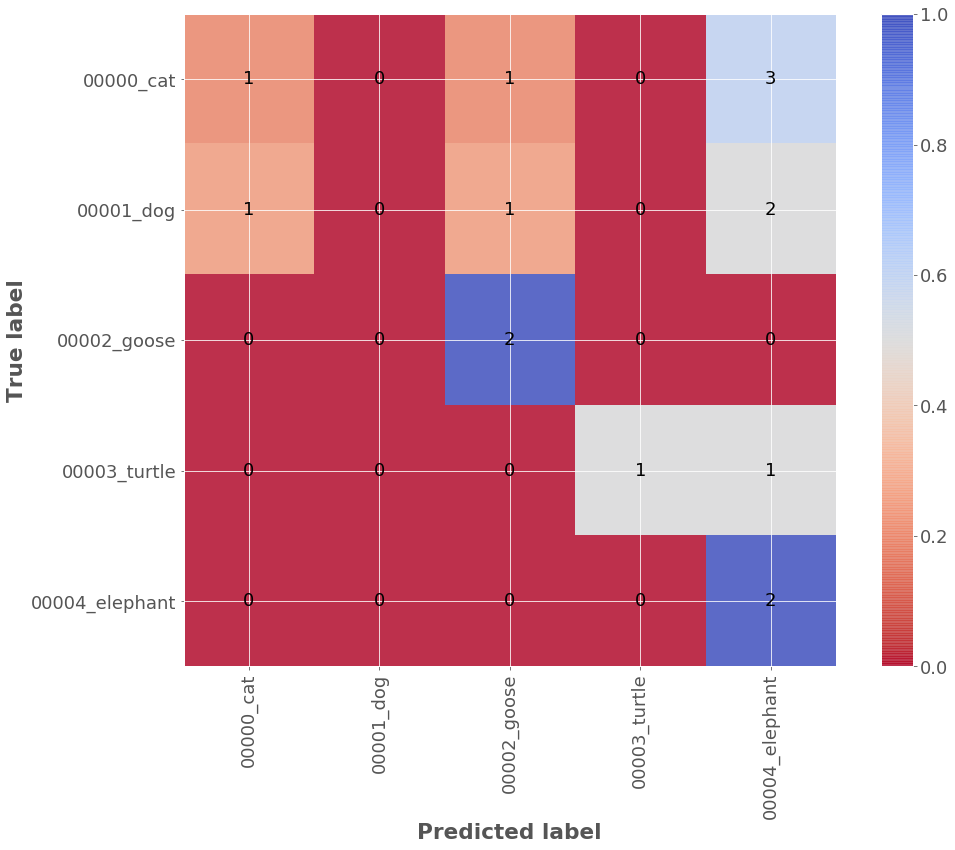

In [61]:
probs, labels = evaluator_granular.evaluate(data_dir=data_dir,top_k=1, filter_indices=None, confusion_matrix=True, save_confusion_matrix_path=None)

In [62]:
evaluator_granular.show_results('average')

,model,accuracy,precision,f1_score,number_of_samples,number_of_classes
0,animals-mobilenet.hdf5,0.4,0.4,0.326,15,5


In [63]:
evaluator_granular.show_results('individual')

,class,sensitivity,precision,f1_score,TP,FP,FN,% of samples
0,00000_cat,0.2,0.50,0.286,1,1,4,33.33
1,00001_dog,0.0,NaN,NaN,0,0,4,26.67
2,00002_goose,1.0,0.50,0.667,2,2,0,13.33
3,00003_turtle,0.5,1.00,0.667,1,0,1,13.33
4,00004_elephant,1.0,0.25,0.400,2,6,0,13.33


#### Evaluation on Coarse classes  

In [64]:
data_dir = 'tests/files/animals/test/'

In [65]:
evaluator_coarse = eval.Evaluator(
        data_dir=data_dir,
        concept_dictionary_path='./tests/files/animals/dictionary.json',
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0
        )

Making predictions from model  0
Input image size:  [299, 299, 3]
Found 15 images belonging to 3 classes.
1/1 [==============================] - 2s 2s/step


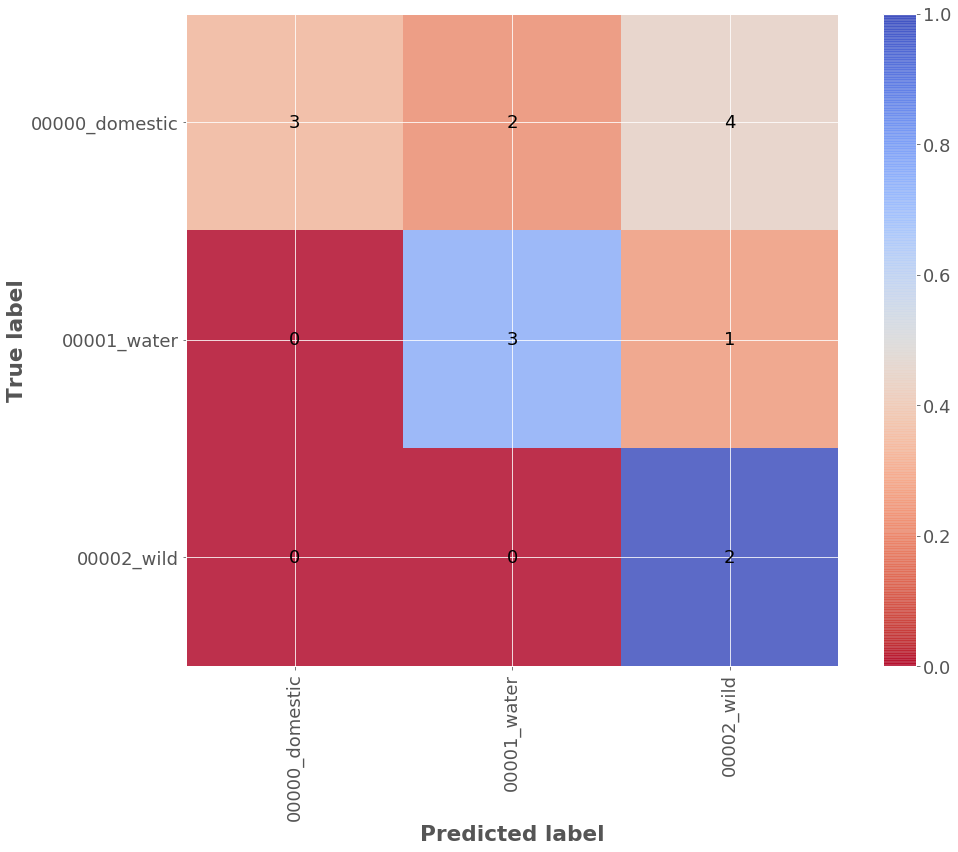

In [66]:
probs, labels = evaluator_coarse.evaluate(data_dir=data_dir,top_k=1, filter_indices=None, confusion_matrix=True, save_confusion_matrix_path=None)

The model was trained on 5 classes but is being evaluated on 3 classes. So we combine the probabilities to 3 classes as seen by the `.shape` method

In [67]:
evaluator_coarse.show_results('average')

,model,accuracy,precision,f1_score,number_of_samples,number_of_classes
0,animals-mobilenet.hdf5,0.533,0.798,0.537,15,3


In [68]:
evaluator_coarse.show_results('individual')

,class,sensitivity,precision,f1_score,TP,FP,FN,% of samples
0,00000_domestic,0.333,1.000,0.500,3,0,6,60.00
1,00001_water,0.750,0.600,0.667,3,2,1,26.67
2,00002_wild,1.000,0.286,0.444,2,5,0,13.33
